# AI-Powered Attrition Prediction System
**Notebook:** attrition_prediction.ipynb  
**Objective:** Predict employee attrition using the IBM HR Analytics dataset.

This notebook performs:
1. Data loading and exploration
2. Preprocessing (encoding, scaling, outlier handling)
3. Visualizations (3+ meaningful charts)
4. Train Random Forest classifier with GridSearchCV
5. Evaluation: Accuracy, Precision, Recall, F1-score, Confusion Matrix, ROC
6. Save model and research brief

In [1]:
# Standard imports
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import joblib

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

## Dataset
We use the IBM HR Analytics dataset from Kaggle:
https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

**How to provide the data:**
1. Place the CSV `WA_Fn-UseC_-HR-Employee-Attrition.csv` in `data/` folder.
2. OR use Kaggle API in Colab/local.

In [5]:
DATA_DIR = Path("../data")

# Dataset file name
csv_file = "WA_Fn-UseC_-HR-Employee-Attrition.csv"

data_path = DATA_DIR / csv_file

if not data_path.exists():
    print("Dataset not found. Please place it in the data/ folder parallel to notebooks/")
else:
    print("Loading dataset from:", data_path)
    df = pd.read_csv(data_path)
    print("Shape:", df.shape)
    display(df.head())

Loading dataset from: ..\data\WA_Fn-UseC_-HR-Employee-Attrition.csv
Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [6]:
# Basic info
df.info()
print("\n---\n")
display(df.describe(include='all').T)
print("\nMissing values per column:")
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1470.0,NaN,NaN,NaN,36.92381,9.135373,18.0,30.0,36.0,43.0,60.0
Attrition,1470,2,No,1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,1470,3,Travel_Rarely,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DailyRate,1470.0,NaN,NaN,NaN,802.485714,403.5091,102.0,465.0,802.0,1157.0,1499.0
Department,1470,3,Research & Development,961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,1470.0,NaN,NaN,NaN,9.192517,8.106864,1.0,2.0,7.0,14.0,29.0
Education,1470.0,NaN,NaN,NaN,2.912925,1.024165,1.0,2.0,3.0,4.0,5.0
EducationField,1470,6,Life Sciences,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeCount,1470.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
EmployeeNumber,1470.0,NaN,NaN,NaN,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0



Missing values per column:


Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

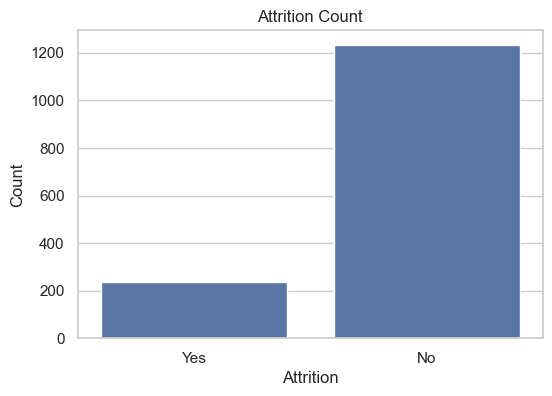

Attrition
No     83.88
Yes    16.12
Name: proportion, dtype: float64


In [7]:
# Target distribution: Attrition (Yes/No)
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Count')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()

print(df['Attrition'].value_counts(normalize=True).mul(100).round(2))

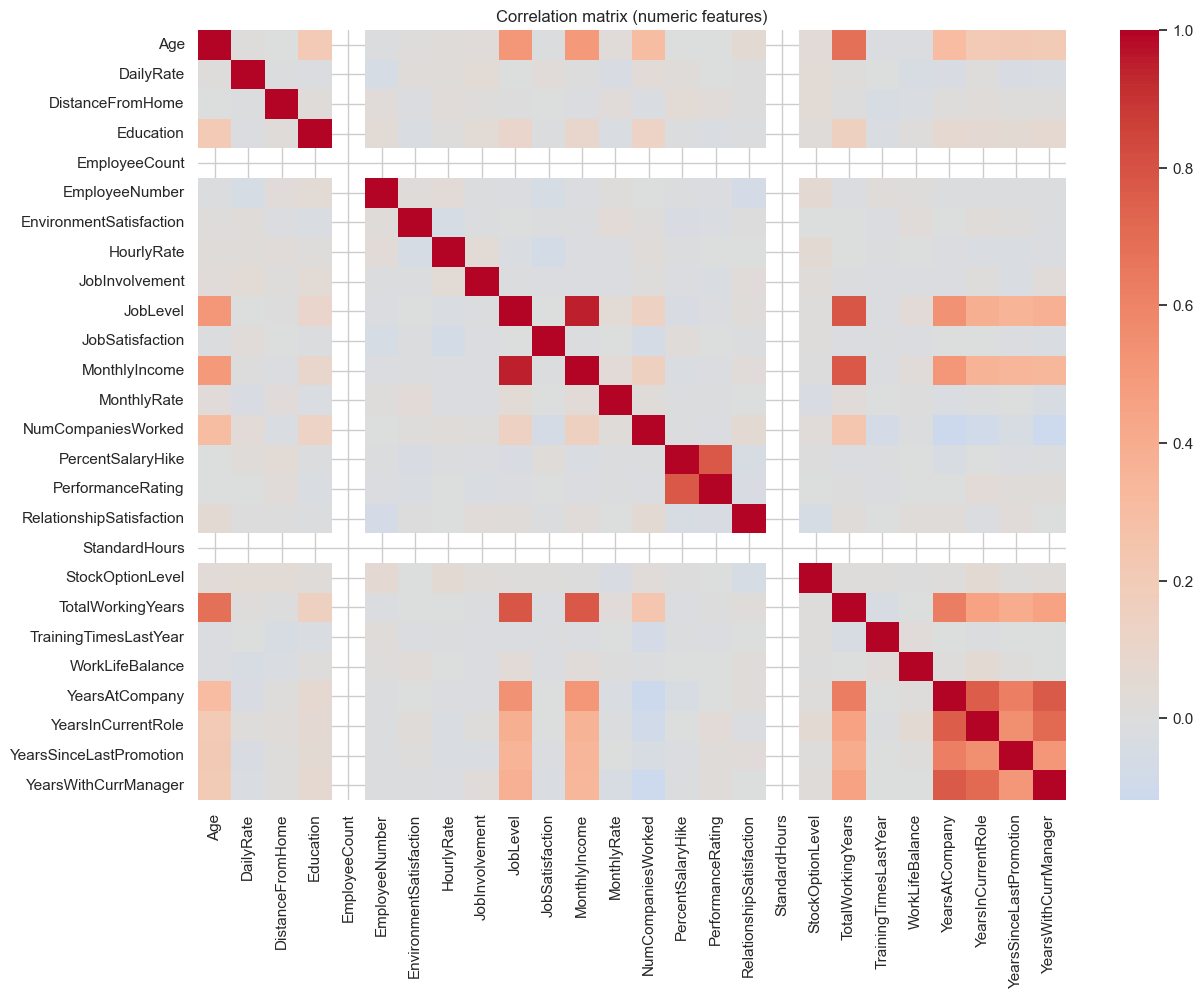

In [8]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(14,10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation matrix (numeric features)')
plt.show()

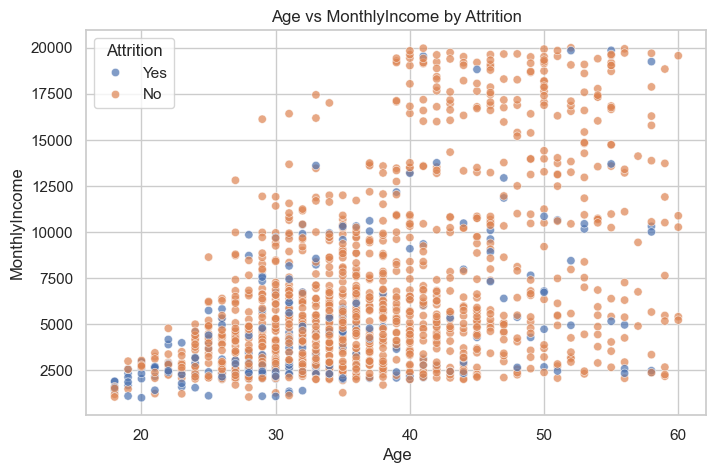

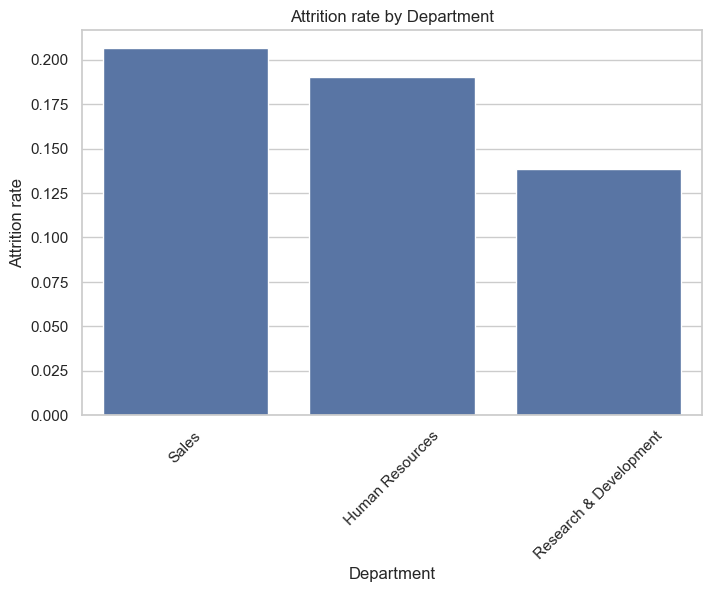

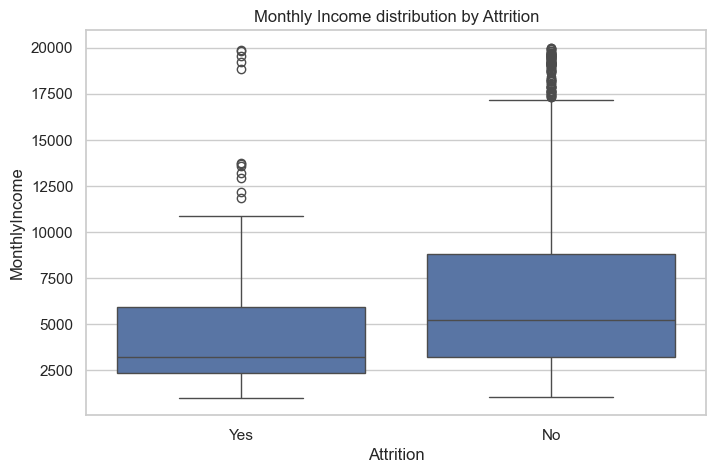

In [9]:
# 1) Age vs MonthlyIncome colored by Attrition
plt.figure(figsize=(8,5))
sns.scatterplot(x='Age', y='MonthlyIncome', hue='Attrition', data=df, alpha=0.7)
plt.title('Age vs MonthlyIncome by Attrition')
plt.show()

# 2) Department-wise attrition rate
dept = df.groupby('Department')['Attrition'].value_counts(normalize=True).unstack().fillna(0)
dept['Attrition_rate'] = dept.get('Yes', 0)
dept = dept.sort_values('Attrition_rate', ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=dept.index, y=dept['Attrition_rate'])
plt.title('Attrition rate by Department')
plt.ylabel('Attrition rate')
plt.xticks(rotation=45)
plt.show()

# 3) MonthlyIncome distribution for Attrition yes/no
plt.figure(figsize=(8,5))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Monthly Income distribution by Attrition')
plt.show()

## Preprocessing Plan
1. Drop EmployeeNumber
2. Convert target Attrition to binary
3. Encode categorical vars
4. Scale numeric features
5. Handle outliers

In [10]:
df_proc = df.copy()
drop_cols = ['EmployeeNumber']
df_proc.drop(columns=[c for c in drop_cols if c in df_proc.columns], inplace=True)
df_proc['Attrition'] = df_proc['Attrition'].map({'Yes':1, 'No':0})
y = df_proc['Attrition']
X = df_proc.drop(columns=['Attrition'])
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


In [11]:
def iqr_clip(series, lower_q=0.01, upper_q=0.99):
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    return series.clip(lower, upper)

X[num_cols] = X[num_cols].apply(iqr_clip)

In [12]:
from sklearn.impute import SimpleImputer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (1176, 33) Test shape: (294, 33)


In [14]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 8, 12],
    'classifier__min_samples_split': [2, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'classifier__max_depth': 12, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV F1: 0.3507873580054031


In [15]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1: {f1:.4f}\nROC-AUC: {roc_auc:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8435
Precision: 0.5556
Recall: 0.1064
F1: 0.1786
ROC-AUC: 0.7809
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.56      0.11      0.18        47

    accuracy                           0.84       294
   macro avg       0.70      0.55      0.55       294
weighted avg       0.81      0.84      0.80       294



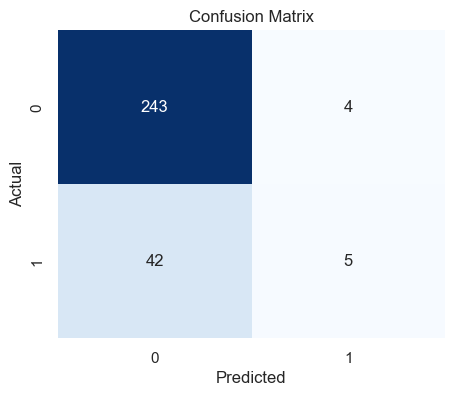

In [16]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

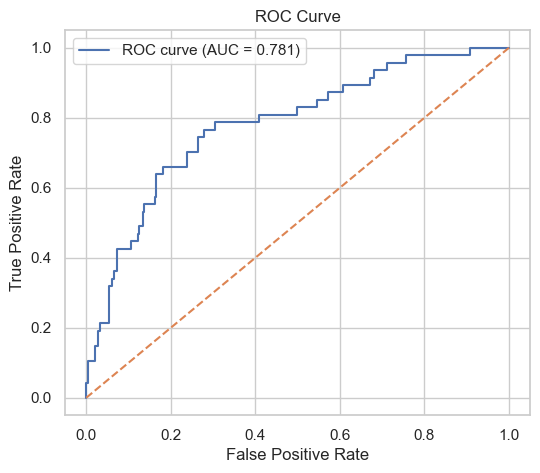

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [18]:
Path("models").mkdir(exist_ok=True)
joblib.dump(best_model, Path("models/random_forest_attrition.pkl"))

['models\\random_forest_attrition.pkl']

In [19]:
Path("report").mkdir(exist_ok=True)
brief = """# Research Brief: Retrieval-Augmented Generation (RAG) — 2025
..."""
with open("report/research_brief.md","w") as f:
    f.write(brief)